In [1]:
!pip install git+https://github.com/trevorstephens/gplearn/

  Cloning https://github.com/trevorstephens/gplearn/ to /tmp/pip-req-build-f9vvjkvq
  Running command git clone -q https://github.com/trevorstephens/gplearn/ /tmp/pip-req-build-f9vvjkvq
  Created wheel for gplearn: filename=gplearn-0.5.dev0-cp36-none-any.whl size=25702 sha256=0c57bee46a5929f4bac3cd0bd224a82a3cd500baff9b23feb3f7c504641becd9
  Stored in directory: /tmp/pip-ephem-wheel-cache-4imazzga/wheels/8d/9b/79/1b1f75b264b076bf25fa3e9bf54de7d1eef40e2c8b3c0c1118
Successfully built gplearn


In [0]:
from gplearn.genetic import SymbolicRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import numpy as np
import graphviz

In [0]:
def fitme(x):
  return(0.1*x*x*x + x*x)

# Training samples
X_train = np.random.uniform(-10, 10, (50,1))
y_train = [fitme(X) for X in X_train]

# Testing samples
X_test = np.random.uniform(-10, 10, (50,1))
y_test = [fitme(X) for X in X_test]

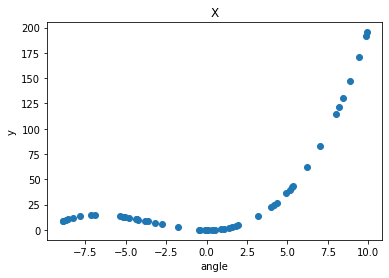

In [4]:
import matplotlib.pyplot as plt

plt.scatter(X_train, y_train)
plt.title('X')
plt.xlabel('angle')
plt.ylabel('y')
plt.show()

In [5]:
est_gp = SymbolicRegressor(population_size=10000,parsimony_coefficient=0.1,
                           function_set=('add', 'mul'))
est_gp.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SymbolicRegressor(const_range=(-1.0, 1.0), feature_names=None,
                  function_set=('add', 'mul'), generations=20,
                  init_depth=(2, 6), init_method='half and half',
                  low_memory=False, max_samples=1.0,
                  metric='mean absolute error', n_jobs=1, p_crossover=0.9,
                  p_hoist_mutation=0.01, p_point_mutation=0.01,
                  p_point_replace=0.05, p_subtree_mutation=0.01,
                  parsimony_coefficient=0.1, population_size=10000,
                  random_state=None, stopping_criteria=0.0, tournament_size=20,
                  verbose=0, warm_start=False)

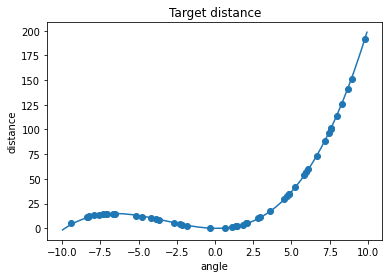

In [6]:
X_lots = np.reshape(np.sort(np.random.uniform(-10, 10, 250)),(-1,1))

y_gp = est_gp.predict(X_lots)

plt.scatter(X_test, y_test)
plt.plot(X_lots, y_gp)
plt.title('Target distance')
plt.xlabel('angle')
plt.ylabel('distance')
plt.show()

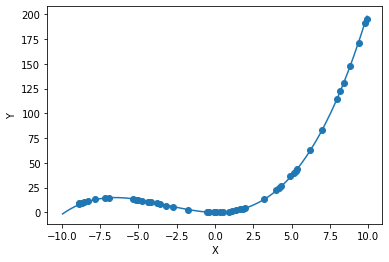

In [7]:
X_lots = np.reshape(np.sort(np.random.uniform(-10, 10, 250)),(-1,1))
 
y_gp = est_gp.predict(X_lots)
 
plt.scatter(X_train, y_train)
plt.plot(X_lots, y_gp)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


In [8]:
print(est_gp._program)

add(add(mul(-0.189, X0), mul(X0, X0)), mul(mul(0.104, X0), mul(X0, X0)))
